# **visualised**

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import scipy.io
from matplotlib import mlab
import scipy.signal
from numpy import linalg

In [3]:
import opendatasets as od

In [4]:
!wget http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip \

--2023-01-02 14:01:07--  http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Resolving bbci.de (bbci.de)... 130.149.80.149
Connecting to bbci.de (bbci.de)|130.149.80.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip [following]
--2023-01-02 14:01:08--  https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Connecting to bbci.de (bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252211988 (241M) [application/zip]
Saving to: ‘BCICIV_1_mat.zip’

BCICIV_1_mat.zip    100%[===================>] 240.53M  18.3MB/s    in 14s     

2023-01-02 14:01:23 (17.0 MB/s) - ‘BCICIV_1_mat.zip’ saved [252211988/252211988]

--2023-01-02 14:01:23--  http://%5C/
Resolving \\ (\\)... failed: Name or service not known.
wget: unable to resolve host address ‘\\’
FINISHED --2023-01-02 14:01:23--
Total wall clock time: 15s
Down

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!unzip \*.zip && rm *.zip

Archive:  BCICIV_1_mat.zip
  inflating: BCICIV_calib_ds1a.mat   
  inflating: BCICIV_calib_ds1b.mat   
  inflating: BCICIV_calib_ds1c.mat   
  inflating: BCICIV_calib_ds1d.mat   
  inflating: BCICIV_calib_ds1e.mat   
  inflating: BCICIV_calib_ds1f.mat   
  inflating: BCICIV_calib_ds1g.mat   
  inflating: BCICIV_eval_ds1a.mat    
  inflating: BCICIV_eval_ds1b.mat    
  inflating: BCICIV_eval_ds1c.mat    
  inflating: BCICIV_eval_ds1d.mat    
  inflating: BCICIV_eval_ds1e.mat    
  inflating: BCICIV_eval_ds1f.mat    
  inflating: BCICIV_eval_ds1g.mat    


In [6]:
!pip install mne
import mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 11.7 MB/s 


In [7]:
import numpy as np
import scipy.io
read = scipy.io.loadmat('/content/BCICIV_calib_ds1g.mat',struct_as_record =True)

In [8]:
import numpy as np
import scipy.io

In [9]:
read.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [10]:
sfreq = read['nfo']['fs'][0][0][0][0]
EEGdata   = read['cnt'].T
nchannels, nsamples = EEGdata.shape

chan_names = [s[0] for s in read['nfo']['clab'][0][0][0]]

event_onsets  = read['mrk'][0][0][0]
event_codes   = read['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in read['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# digitized electrode positions 
xpos = read['nfo']['xpos']
ypos = read['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190602)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [11]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sfreq), int(2.5*sfreq))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGdata[:, win+onset]
        
# the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [12]:
%qtconsole
left_hand  = np.rollaxis(trials[cl1], 2, 0)  
right_hand = np.rollaxis(trials[cl2], 2, 0)  

In [13]:
left_hand.shape

(100, 59, 200)

In [14]:
data = np.concatenate([left_hand, right_hand])

In [15]:
# create labels 
Y = np.concatenate([-np.ones(left_hand.shape[0]),
                     np.ones(right_hand.shape[0])])

In [16]:
import mne

In [17]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sfreq )  

print('Event created :', info)   

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [18]:
# digitized electrode positions 
xpos = read['nfo']['xpos'][0][0]  
ypos = read['nfo']['ypos'][0][0] 

In [19]:
layout_pos = np.concatenate([xpos, ypos], axis = 1)
layout_pos

array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [20]:
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=chan_names,
    name ='EEG custom layout',
    )

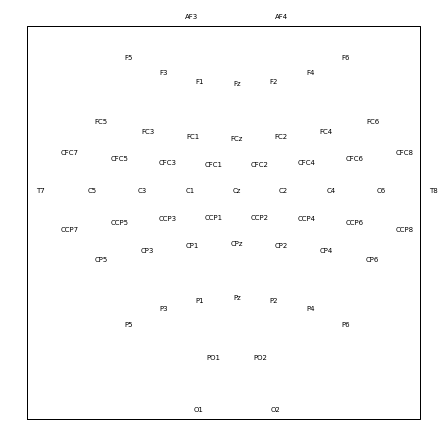

In [21]:
layout.plot();

In [22]:
event_id = dict(left = -1, right = 1)

In [23]:
# Create an event matrix: events with alternating event codes
eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [24]:
events

array([[    0,     0,    -1],
       [  300,     0,    -1],
       [  600,     0,    -1],
       [  900,     0,    -1],
       [ 1200,     0,    -1],
       [ 1500,     0,    -1],
       [ 1800,     0,    -1],
       [ 2100,     0,    -1],
       [ 2400,     0,    -1],
       [ 2700,     0,    -1],
       [ 3000,     0,    -1],
       [ 3300,     0,    -1],
       [ 3600,     0,    -1],
       [ 3900,     0,    -1],
       [ 4200,     0,    -1],
       [ 4500,     0,    -1],
       [ 4800,     0,    -1],
       [ 5100,     0,    -1],
       [ 5400,     0,    -1],
       [ 5700,     0,    -1],
       [ 6000,     0,    -1],
       [ 6300,     0,    -1],
       [ 6600,     0,    -1],
       [ 6900,     0,    -1],
       [ 7200,     0,    -1],
       [ 7500,     0,    -1],
       [ 7800,     0,    -1],
       [ 8100,     0,    -1],
       [ 8400,     0,    -1],
       [ 8700,     0,    -1],
       [ 9000,     0,    -1],
       [ 9300,     0,    -1],
       [ 9600,     0,    -1],
       [ 9

In [25]:
# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
tmin = 0.5                

# Create the :class:`mne.EpochsArray` object
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


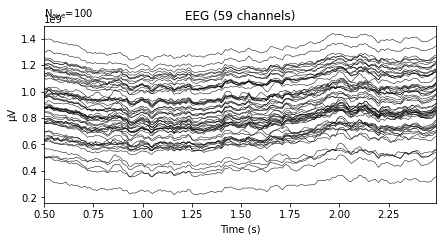

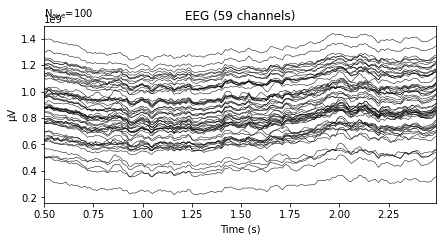

In [26]:
epochs['left'].average().plot()

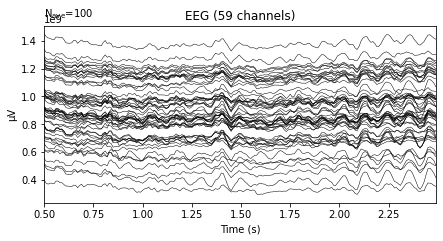

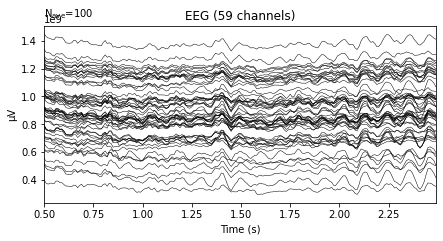

In [27]:
epochs['right'].average().plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


<ipython-input-28-697022bd73f1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


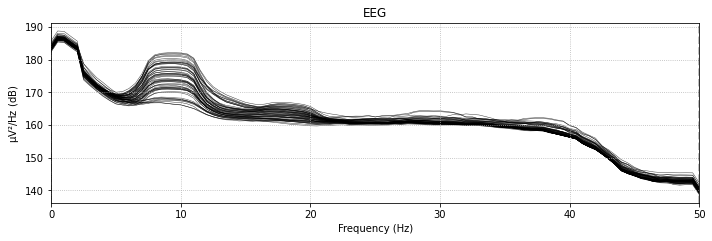

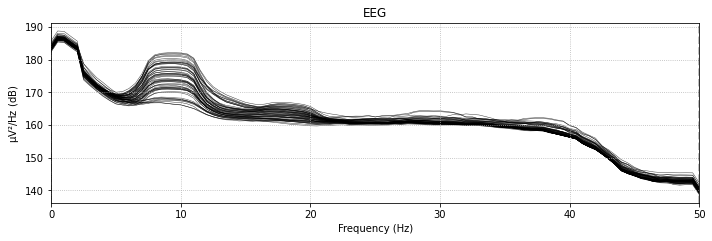

In [28]:
epochs.plot_psd()

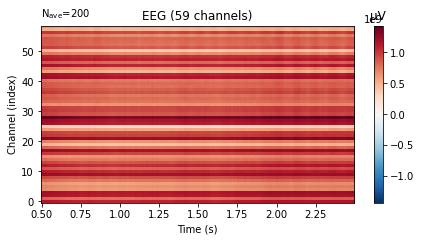

In [29]:
epochs.average().plot_image();

In [30]:
epochs.filter(l_freq=8, h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    3.3s finished


Number of events,200
Events,left: 100right: 100
Time range,0.500 – 2.490 sec
Baseline,off


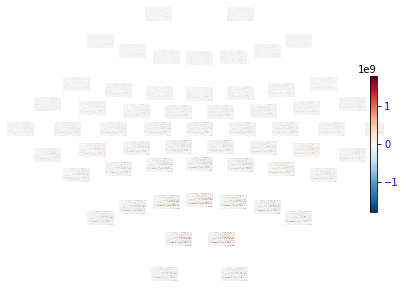

In [31]:
epochs.plot_topo_image(layout=layout, 
                       fig_facecolor='w', font_color='b');

In [32]:
import numpy as np
import scipy.io
from matplotlib import mlab
import matplotlib.pyplot as plt
import scipy.signal
from numpy import linalg

# **Model**

In [33]:
m = scipy.io.loadmat('/content/BCICIV_calib_ds1g.mat', struct_as_record=True) # load data from matlab file

#get informtion
sample_rate = m['nfo']['fs'][0][0][0][0] #sample rate
EEG = m['cnt'].T # the EEG signal
nchannels, nsamples = EEG.shape # num of channels and num of sample 

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]] # channel names
event_onsets = m['mrk'][0][0][0] # start of every event
event_codes = m['mrk'][0][0][1] # event codes

# get labels
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

# get classes
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [34]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', nevents)
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190602)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [35]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

In [36]:
# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

In [37]:
# (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [38]:
# Calculates for each trial the Power Spectral Density (PSD).
def psd(trials):
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [39]:
psd_l, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_f}

In [40]:
# Plots PSD data calculated with psd().
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    
    plt.figure(figsize=(20,8))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # x-axis limit
        plt.xlim(1,30)
        
        # y-axis limit
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        # titles for plots
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

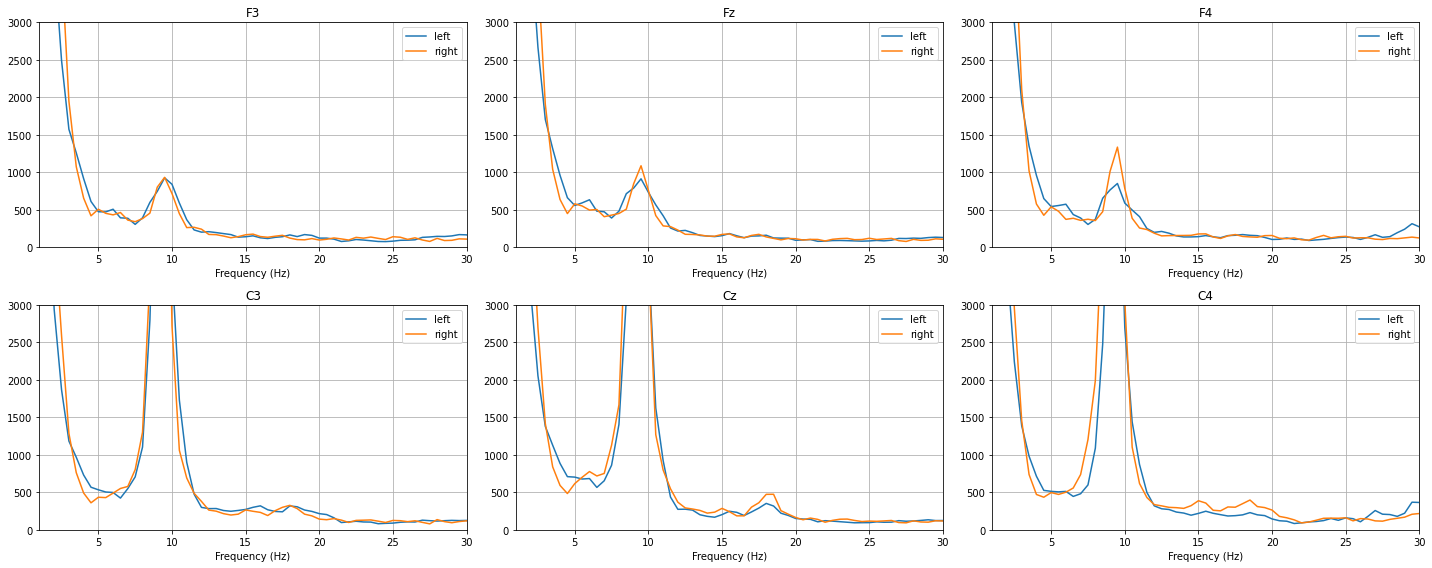

In [41]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['F3', 'Fz', 'F4','C3', 'Cz', 'C4']],
    chan_lab=['F3', 'Fz', 'F4','C3', 'Cz', 'C4'],
    maxy=3000
)

In [42]:
# Designs and applies a bandpass filter to the signal.
def bandpass(trials, lo, hi, sample_rate):
  
    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [43]:
# strip away frequencies outside the 8--15Hz window (Beta)
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

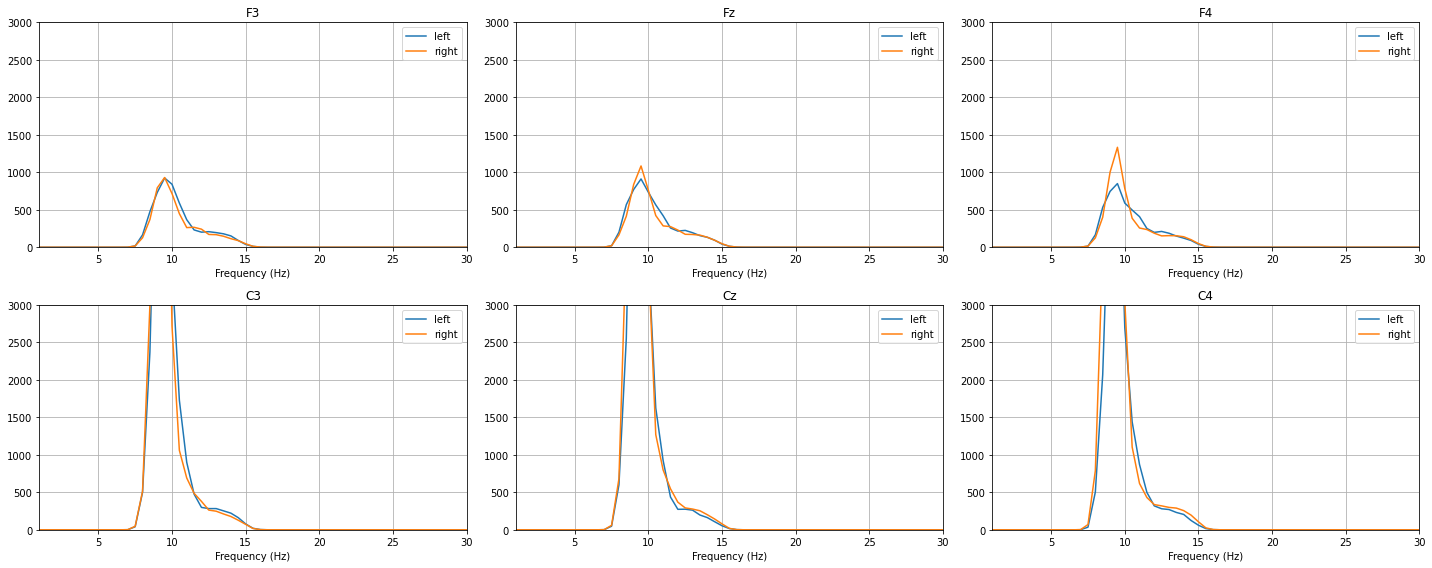

In [44]:
# Plotting the PSD of the resulting trials_filt
psd_l, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_l, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['F3', 'Fz', 'F4','C3', 'Cz', 'C4']],
    chan_lab=['F3', 'Fz', 'F4','C3', 'Cz', 'C4'],
    maxy=3000
)

In [45]:
# Calculate the log(var) of the trials
def logvar(trials):
  
    return np.log(np.var(trials, axis=1))

In [46]:
# we will use the logarithm of the variance of each channel as a feature for the classifier
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}

In [47]:
# Plots the log-var of each channel/component.
def plot_logvar(trials):

    plt.figure(figsize=(20,6))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

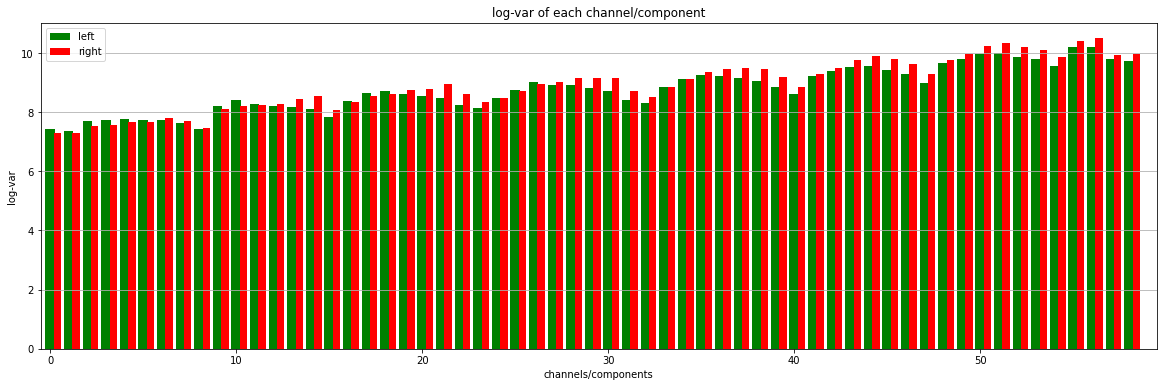

In [48]:
# Plot the log-vars
plot_logvar(trials_logvar)

In [49]:
# Calculate the covariance for each trial and return their average 
def cov(trials):
    
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

In [50]:
# Calculate a whitening matrix for covariance matrix sigma. 
def whitening(sigma):
    
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

In [51]:
# Calculate the CSP transformation matrix W.
def csp(trials_r, trials_f):
  
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

In [52]:
# Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)
def apply_mix(W, trials):
    
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [53]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

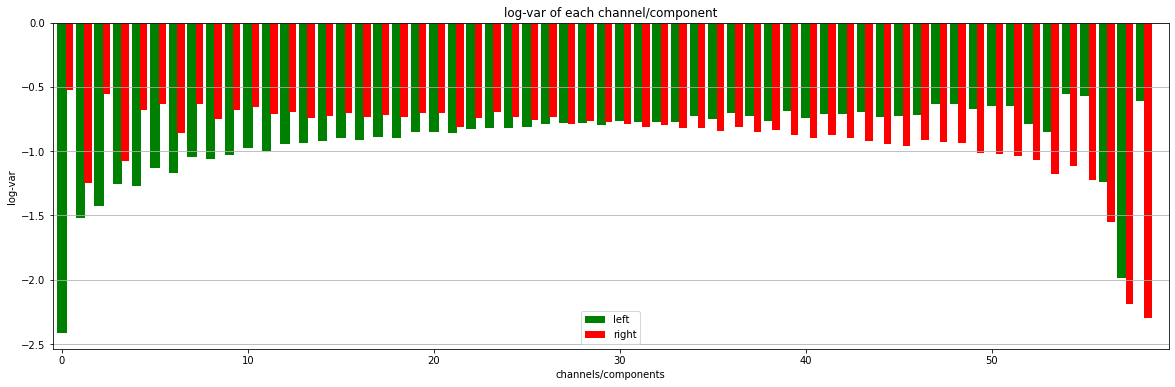

In [54]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

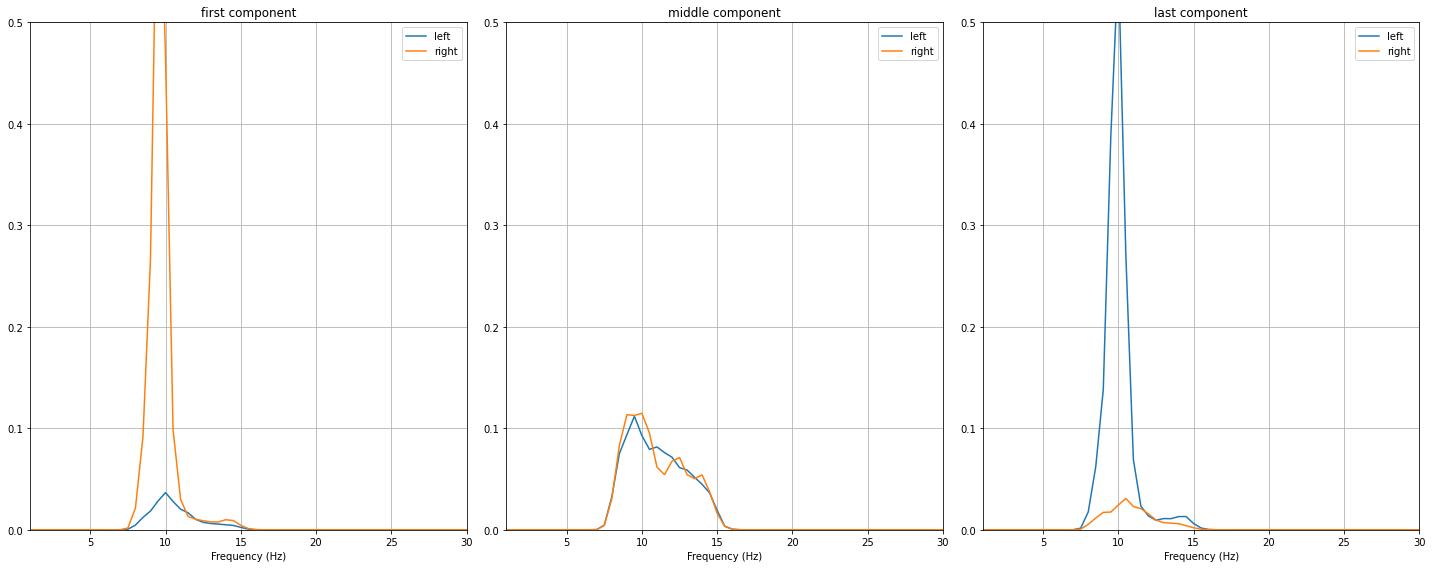

In [55]:
# plots the PSD for the first and last components as well as one in the middle
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_r,
              cl2: psd_f}

plot_psd(trials_PSD,
         freqs,
         [0,28,-1],
         chan_lab=['first component', 'middle component', 'last component'],
         maxy=0.5 )

In [56]:
# a scatter plot to see differentiate between the two classes
def plot_scatter(cl1, cl2):
    plt.figure()
    plt.scatter(cl1[0,:], cl1[-1,:], color='b')
    plt.scatter(cl2[0,:], cl2[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

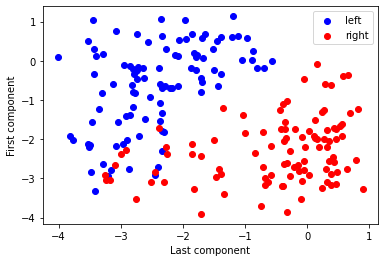

In [57]:
# the x-axis is the first CSP component, the y-axis is the last
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [58]:
# Percentage of trials to use for training (80-20 split here)
train_percentage = 0.8 

# Calculate the number of trials for each class the above percentage boils down to
ntrain_l = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_l
ntest_f = trials_filt[cl2].shape[2] - ntrain_f

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_l],
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_l:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

# Select only the first and last components for classification 
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [59]:
# the LDA algorithm
def train_lda(class1, class2):

    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    

    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

In [60]:
# function predict new data.
def predict_lda(test, W, b):
  
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):

        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [61]:
# train the model
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [ 3.54614573 -3.27647797]
b: -0.43251864689564457


<Figure size 1440x1440 with 0 Axes>

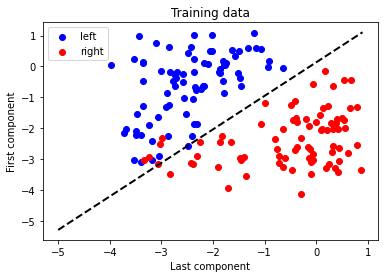

In [62]:
# Scatterplot
plt.figure(figsize=(20,20))
plot_scatter(train[cl1], train[cl2])
plt.title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')


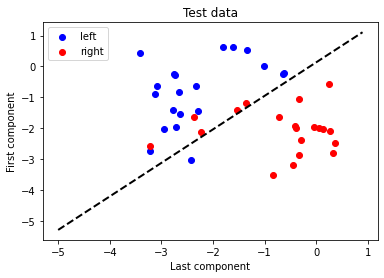

In [63]:
plot_scatter(test[cl1], test[cl2])
plt.title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')

In [64]:
# Print confusion matrix for train data
conf = np.array([
    [(predict_lda(train[cl1], W, b) == 1).sum(), (predict_lda(train[cl2], W, b) == 1).sum()],
    [(predict_lda(train[cl1], W, b) == 2).sum(), (predict_lda(train[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.4f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[80  5]
 [ 0 75]]

Accuracy: 0.9688


In [65]:
# Print confusion matrix for test data
conf = np.array([
    [(predict_lda(test[cl1], W, b) == 1).sum(), (predict_lda(test[cl2], W, b) == 1).sum()],
    [(predict_lda(test[cl1], W, b) == 2).sum(), (predict_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.4f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[19  5]
 [ 1 15]]

Accuracy: 0.8500
